In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import proplot as plot
# import scipy.interpolate

## Constants

In [2]:
# constant
R = 287.3
T0 = 273.15
g0 = 9.80665
p0 = 1.01325e5
ts = 220  # temperature of cross-section [K]

## Read data file

In [3]:
# read s5p data
s5p_file = './S5P_TEST_L2__NO2____20190725T042743_20190725T060912_09219_01_020100_20190911T091424.nc'
s5p_root = xr.open_dataset(s5p_file, group='PRODUCT')
s5p_input = xr.open_dataset(s5p_file, group='PRODUCT/SUPPORT_DATA/INPUT_DATA/')
s5p_geo = xr.open_dataset(s5p_file, group='PRODUCT/SUPPORT_DATA/GEOLOCATIONS/')
s5p_detail = xr.open_dataset(s5p_file, group='PRODUCT/SUPPORT_DATA/DETAILED_RESULTS/')

# read lut data
lut = xr.open_dataset('S5P_OPER_LUT_NO2AMF_00000000T000000_99999999T999999_20160527T173500.nc')

## Read variables

In [4]:
# basic variables
amfClr = s5p_detail['air_mass_factor_clear']
amfCld = s5p_detail['air_mass_factor_cloudy']
ghost = s5p_detail['nitrogendioxide_ghost_column']*1e15  # bug of official data
crf = s5p_detail['cloud_radiance_fraction_nitrogendioxide_window']
a = s5p_root['tm5_constant_a']
b = s5p_root['tm5_constant_b']
itropo = s5p_root['tm5_tropopause_layer_index']
p_sfc = s5p_input['surface_pressure']
p_cld = s5p_input['cloud_pressure_crb']

albedo = s5p_input['surface_albedo']
cld_albedo = s5p_input['cloud_albedo_crb']

sza = s5p_geo['solar_azimuth_angle']
vza = s5p_geo['viewing_azimuth_angle']

raa = abs(vza - sza)
raa = xr.where(raa <= 180, raa, 360 - raa).rename('relative_azimuth_angle')

mu0 = np.cos(np.deg2rad(s5p_geo['solar_zenith_angle']))
mu = np.cos(np.deg2rad(s5p_geo['viewing_zenith_angle']))

no2_profile = s5p_detail['no2_vmr']
tk = s5p_detail['temperature']

# pressure levels
base_p = (a[:, 0] + b[:, 0]*p_sfc).rename('base_pressure')/1e2
top_p = (a[:, 1] + b[:, 1]*p_sfc).rename('top_pressure')/1e2

# set units
p_sfc /= 1e2
p_cld /= 1e2
p_sfc.attrs['units'] = 'hPa'
p_cld.attrs['units'] = 'hPa'
base_p.attrs['units'] = 'hPa'
top_p.attrs['units'] = 'hPa'

## Layer structure

The number of TM5-MP layers is N$_{l}$ = 34.

Note: the TM5 layer index is **from 0 to 33**.

In [5]:
display(no2_profile.layer, tk.layer, base_p.layer, top_p.layer)

<xarray.DataArray 'layer' (layer: 34)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])
Dimensions without coordinates: layer

<xarray.DataArray 'layer' (layer: 34)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])
Dimensions without coordinates: layer

<xarray.DataArray 'layer' (layer: 34)>
array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
       28., 29., 30., 31., 32., 33.])
Coordinates:
  * layer     (layer) float64 0.0 1.0 2.0 3.0 4.0 ... 29.0 30.0 31.0 32.0 33.0
    vertices  float64 0.0
Attributes:
    standard_name:  atmosphere_hybrid_sigma_pressure_coordinate
    units:          1
    long_name:      TM5 atmospheric layer numbers
    positive:       down
    axis:           Z
    formula_terms:  ap: tm5_constant_a b: tm5_constant_b ps: /PRODUCT/SUPPORT...
    comment:        p(t, k, j, i, l) = ap(k, l) + b(k, l)*ps(t, j, i); k from...

<xarray.DataArray 'layer' (layer: 34)>
array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
       28., 29., 30., 31., 32., 33.])
Coordinates:
  * layer     (layer) float64 0.0 1.0 2.0 3.0 4.0 ... 29.0 30.0 31.0 32.0 33.0
    vertices  float64 1.0
Attributes:
    standard_name:  atmosphere_hybrid_sigma_pressure_coordinate
    units:          1
    long_name:      TM5 atmospheric layer numbers
    positive:       down
    axis:           Z
    formula_terms:  ap: tm5_constant_a b: tm5_constant_b ps: /PRODUCT/SUPPORT...
    comment:        p(t, k, j, i, l) = ap(k, l) + b(k, l)*ps(t, j, i); k from...

The difinition of `layer` in the S5P L2 PUM Nitrogendioxide Page 36:

<img src="./pics/layer.png" alt="layer" width="500"/>

So, the `layer` is the **half levels** or model levels as shown in [this example](https://rda.ucar.edu/datasets/ds627.2/docs/Eta_coordinate/):

```
                                                                                  a (Pa)      b (Pa Pa-1)

================== TOP OF MODEL ATMOSPHERE ===================== i = 1         a =  0.00000   b = 0.00000

  ---------------------- model level ------- (data) ---------- j = 1           a = 10.00000   b = 0.00000

========================= interface ============================ i = 2         a = 20.00000   b = 0.00000

  ---------------------- model level ------- (data) ---------- j = 2           a = 28.21708   b = 0.00000

========================= interface ============================ i = 3         a = 38.42530   b = 0.00000



  ---------------------- model level ------- (data) ---------- j - 1

========================= interface ============================ i - 1

  ---------------------- model level ------- (data) ---------- j

========================= interface ============================ i

  ---------------------- model level ------- (data) ---------- j + 1



========================= interface ============================ i = 59        a =  7.36774   b = 0.99402

  ---------------------- model level ------- (data) ---------- j = 59          a =  3.68387   b = 0.99582

========================= interface ============================ i = 60        a =  0.00000   b = 0.99763

  ---------------------- model level ------- (data) ---------- j = 60 = J      a =  0.00000   b = 0.99881

======================= MODEL SURFACE ========================== i = 61 = I    a =  0.00000   b = 1.00000
```

## Calculate Tropopause

There're some nan values in the `itropo` and We have to set them to `0` first:

In [6]:
tropo_bool = itropo.isnull()
itropo = xr.where(tropo_bool, 0, itropo).astype('int')
itropo

<xarray.DataArray 'tm5_tropopause_layer_index' (time: 1, scanline: 389, ground_pixel: 450)>
array([[[ 0, 20, 20, ..., 20, 20, 20],
        [ 0, 20, 20, ..., 20, 20, 20],
        [ 0, 20, 20, ..., 20, 20, 20],
        ...,
        [ 0, 21, 21, ..., 20, 20, 20],
        [ 0, 21, 21, ..., 20, 20, 20],
        [ 0, 20, 21, ..., 20, 20, 20]]])
Coordinates:
  * scanline      (scanline) float64 1.54e+03 1.541e+03 ... 1.927e+03 1.928e+03
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 447.0 448.0 449.0
  * time          (time) datetime64[ns] 2019-07-25
    latitude      (time, scanline, ground_pixel) float32 13.932586 ... 43.42534
    longitude     (time, scanline, ground_pixel) float32 108.463 ... 129.93388

 Then, masking fill_values after getting the tropopause values:

In [7]:
base_tropo = base_p.isel(layer=itropo.load())
top_tropo = top_p.isel(layer=itropo.load())
# mask with where and set fill_value pixels to nan
base_tropo = xr.where(tropo_bool, np.nan, base_tropo).rename('base_tropo')
top_tropo = xr.where(tropo_bool, np.nan, top_tropo).rename('top_tropo')

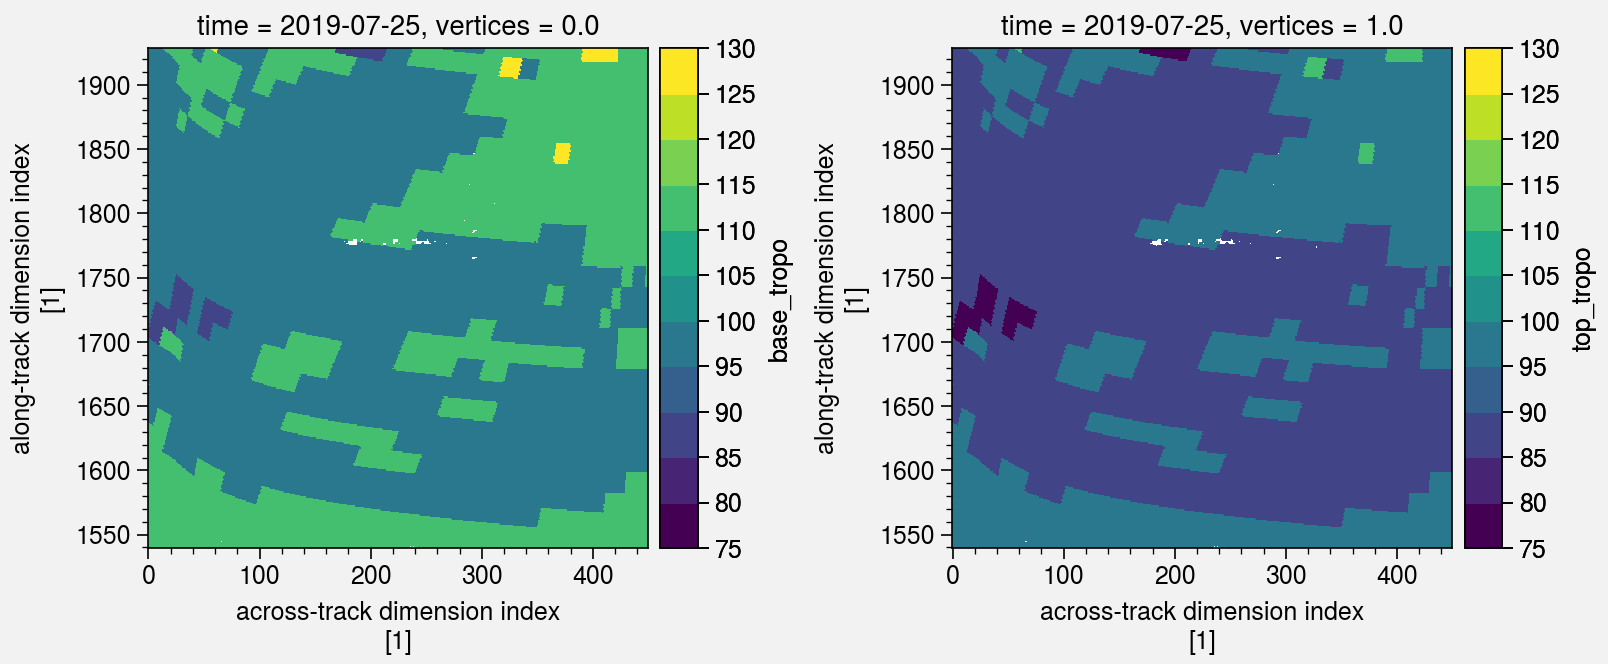

In [8]:
# quickview
fig, axs = plot.subplots(share=0, ncols=2)
base_tropo.plot(ax=axs[0], vmin=75, vmax=130)
top_tropo.plot(ax=axs[1], vmin=75, vmax=130)

## Choosing Case

Now, it's time to choose one case to reproduce some variables by ourself and compare them with the official products.

To make indexing easier, we can concatenate these DataArrays into one Dataset:

In [9]:
ds = xr.merge([amfClr, amfCld, ghost,
               crf, albedo, cld_albedo,
               raa, mu0, mu,
               no2_profile, tk,
               p_sfc, p_cld,
               base_p.drop_vars('vertices'),
               top_p.drop_vars('vertices'),
               base_tropo.drop_vars('vertices'),
               top_tropo.drop_vars('vertices'),
               ghost],
              )

# pick one pixel
scanline = 275
ground_pixel = 246

ds = ds.isel(time=0, scanline=scanline, ground_pixel=ground_pixel)

display(ds)

<xarray.Dataset>
Dimensions:                                         (layer: 34)
Coordinates:
    ground_pixel                                    float64 246.0
    scanline                                        float64 1.815e+03
    time                                            datetime64[ns] 2019-07-25
  * layer                                           (layer) float64 0.0 ... 33.0
    latitude                                        float32 35.749756
    longitude                                       float32 116.56032
Data variables:
    air_mass_factor_clear                           float32 ...
    air_mass_factor_cloudy                          float32 ...
    nitrogendioxide_ghost_column                    float32 6456798000000000.0
    cloud_radiance_fraction_nitrogendioxide_window  float32 ...
    surface_albedo                                  float32 ...
    cloud_albedo_crb                                float32 ...
    relative_azimuth_angle                          float32 32.501846
    solar_zenith_angle                              float32 0.93355525
    viewing_zenith_angle                            float32 0.9948532
    no2_vmr                                         (layer) float32 ...
    temperature                                     (layer) float32 ...
    surface_pressure                                float32 994.9514
    cloud_pressure_crb                              float32 752.93353
    base_pressure                                   (layer) float32 994.9514 ...
    top_pressure                                    (layer) float32 987.2042 ...
    base_tropo                                      float32 112.05213
    top_tropo                                       float32 95.82482

## Pressure levels

Quickview of the pressure levels:

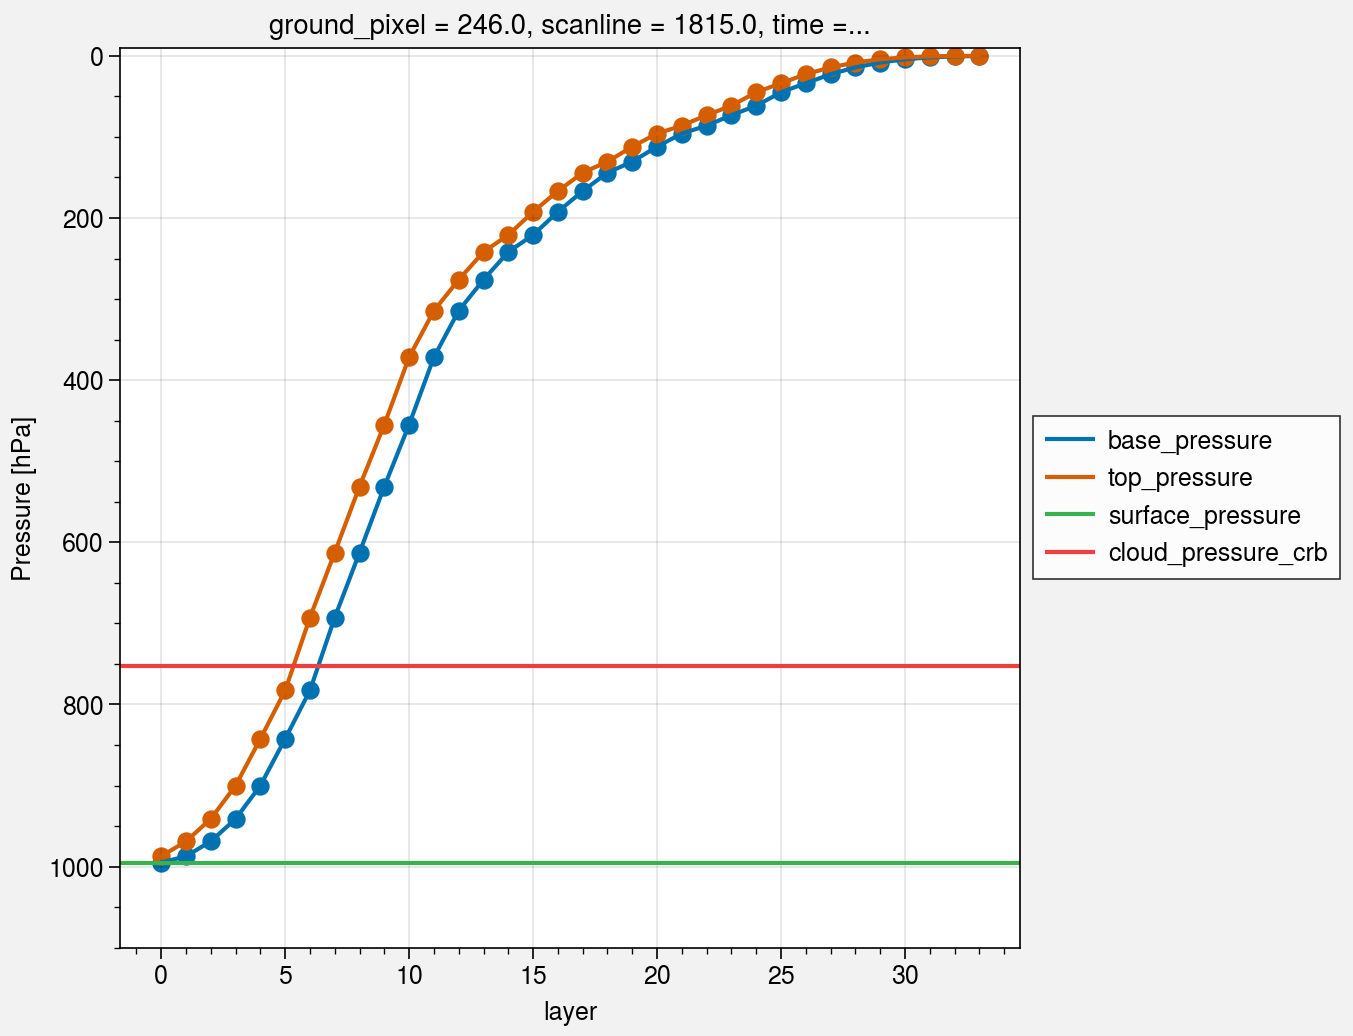

In [10]:
fig, axs = plot.subplots(axwidth=4.5)

l1 = ds['base_pressure'].plot(ax=axs, label='base_pressure')
l2 = ds['top_pressure'].plot(ax=axs, label='top_pressure')
l3 = axs.axhline(ds['surface_pressure'], color='green7', label='surface_pressure')
l4 = axs.axhline(ds['cloud_pressure_crb'], color='red7', label='cloud_pressure_crb')

ds.plot.scatter(x='layer', y='base_pressure', ax=axs)
ds.plot.scatter(x='layer', y='top_pressure', ax=axs)

axs.legend([l1, l2, l3, l4], ncols=1, loc='r')
axs.format(ylim=(1100, -10), ylabel='Pressure [hPa]')

### Layer index of `surface_pressure`

In [11]:
ds['surface_pressure'] > ds['base_pressure']

<xarray.DataArray (layer: 34)>
array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])
Coordinates:
    ground_pixel  float64 246.0
    scanline      float64 1.815e+03
    time          datetime64[ns] 2019-07-25
    latitude      float32 35.749756
    longitude     float32 116.56032
  * layer         (layer) float64 0.0 1.0 2.0 3.0 4.0 ... 30.0 31.0 32.0 33.0

In [12]:
(ds['surface_pressure'] > ds['base_pressure']).argmax()

<xarray.DataArray ()>
array(1)
Coordinates:
    ground_pixel  float64 246.0
    scanline      float64 1.815e+03
    time          datetime64[ns] 2019-07-25
    latitude      float32 35.749756
    longitude     float32 116.56032

Note:

According to the method mentioned in the ATBD (Page 30):

> For out-of-bounds values (there is a slight chance that this occurs for surface pressure or atmospheric pressure) we use the point nearest to the LUT reference point (e.g. when surface pressure would be 1051 hPa, we will use the 1048 hPa reference point).

We need to set the layer index of `surface_pressure` to 0 if the result is all `True`:

In [13]:
id_sfc = max(0, (ds['surface_pressure'] > ds['base_pressure']).argmax().values - 1)

### Layer index of `cloud_pressure_crb`

In [14]:
ds['cloud_pressure_crb'] > ds['base_pressure']

<xarray.DataArray (layer: 34)>
array([False, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])
Coordinates:
    ground_pixel  float64 246.0
    scanline      float64 1.815e+03
    time          datetime64[ns] 2019-07-25
    latitude      float32 35.749756
    longitude     float32 116.56032
  * layer         (layer) float64 0.0 1.0 2.0 3.0 4.0 ... 30.0 31.0 32.0 33.0

In [15]:
(ds['cloud_pressure_crb'] > ds['base_pressure']).argmax()

<xarray.DataArray ()>
array(7)
Coordinates:
    ground_pixel  float64 246.0
    scanline      float64 1.815e+03
    time          datetime64[ns] 2019-07-25
    latitude      float32 35.749756
    longitude     float32 116.56032

In [16]:
id_cld = (ds['cloud_pressure_crb'] > ds['base_pressure']).argmax().values - 1

According to the figure, `id_sfc` and `id_cld` should be 0 and 6, respectively:

In [17]:
id_sfc, id_cld

(0, 6)

## Concatenating NO$_2$

Let's check if the layer index is right:

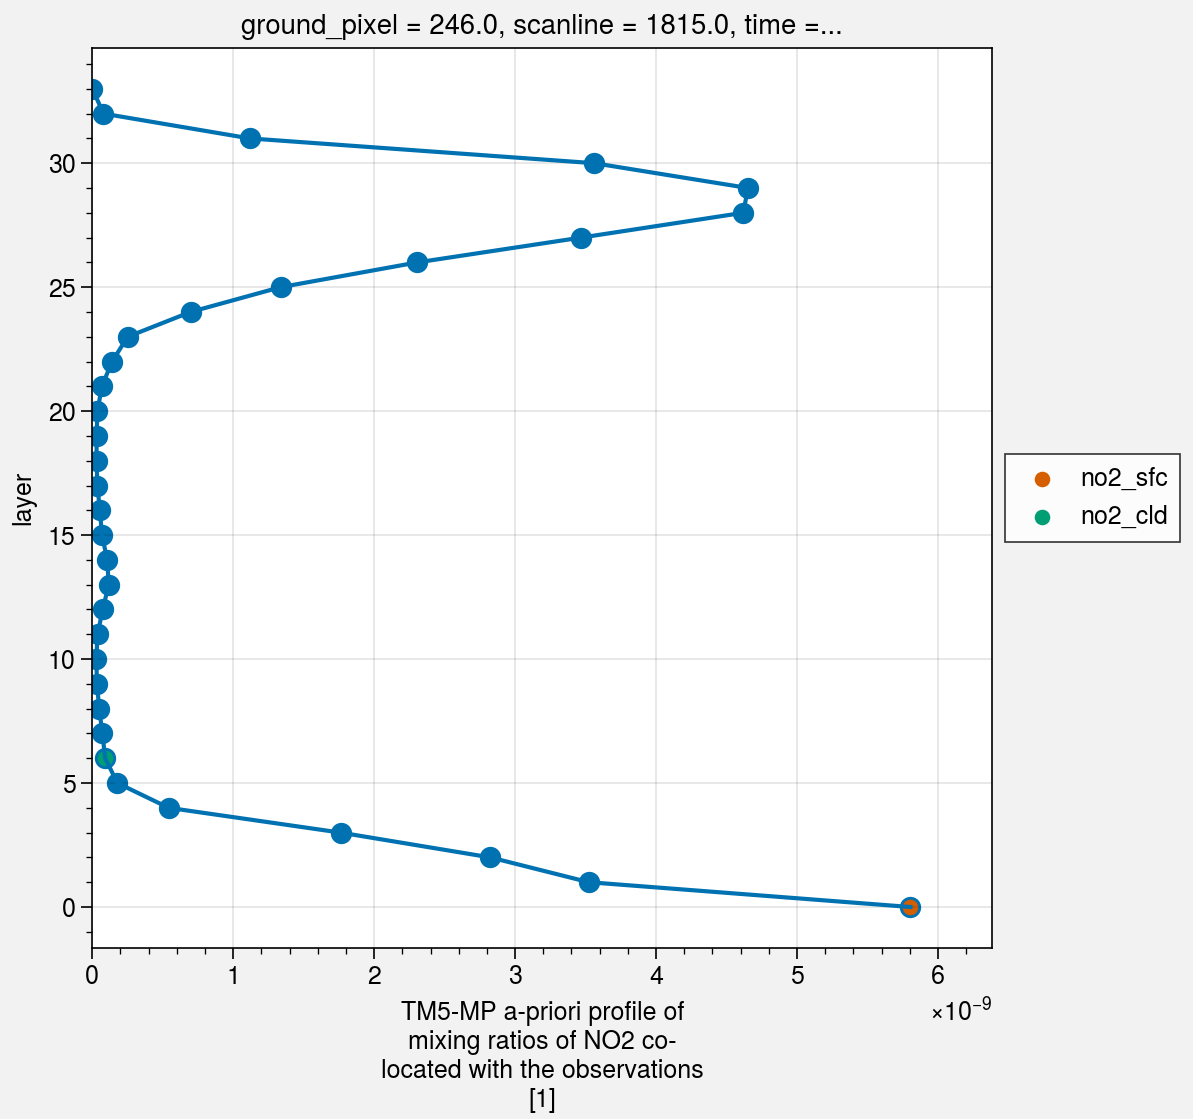

In [18]:
fig, axs = plot.subplots(axwidth=4.5)

# plot the TM5 no2 profile at default layer index
ds['no2_vmr'].plot(y='layer', ax=axs)
ds.plot.scatter(x='no2_vmr', y='layer', s=50, ax=axs)

# plot the scatter at the layers of surface and cloud
s1 = axs.scatter(ds['no2_vmr'].sel(layer=id_sfc), id_sfc, label='no2_sfc', s=25)
s2 = axs.scatter(ds['no2_vmr'].sel(layer=id_cld), id_cld, label='no2_cld', s=25)

axs.format(xlim=(0, ds['no2_vmr'].max()*1.1))
axs.legend([s1, s2], loc='r', ncols=1)

The most diffcuclt part is how to add these two no2 points into the profile.

In [19]:
# concatenate the pressure levels first
p_cld = xr.DataArray(np.atleast_1d(ds['cloud_pressure_crb']), dims=['layer'], coords={'layer': np.array([id_cld])})
p_sfc = xr.DataArray(np.atleast_1d(ds['surface_pressure']), dims=['layer'], coords={'layer': np.array([id_sfc])})
p_level = xr.concat([ds['base_pressure'], p_sfc, p_cld], dim='layer')

# then no2
no2_sfc = ds['no2_vmr'].sel(layer=id_sfc)
no2_cld = ds['no2_vmr'].sel(layer=id_cld)
no2_profile = xr.concat([ds['no2_vmr'], no2_sfc, no2_cld], dim='layer')

display(p_level, no2_profile)

<xarray.DataArray 'base_pressure' (layer: 36)>
array([9.9495142e+02, 9.8720422e+02, 9.6886249e+02, 9.4105182e+02,
       9.0008954e+02, 8.4236884e+02, 7.8274518e+02, 6.9279388e+02,
       6.1263489e+02, 5.3116370e+02, 4.5481528e+02, 3.7167538e+02,
       3.1432071e+02, 2.7615833e+02, 2.4182451e+02, 2.2091837e+02,
       1.9233003e+02, 1.6682896e+02, 1.4416415e+02, 1.3051131e+02,
       1.1205213e+02, 9.5824821e+01, 8.6143951e+01, 7.3118690e+01,
       6.1560741e+01, 4.4908173e+01, 3.3817436e+01, 2.2654316e+01,
       1.4237701e+01, 8.2396784e+00, 4.2759252e+00, 1.9133856e+00,
       6.9520575e-01, 1.8608931e-01, 9.9495142e+02, 7.5293353e+02],
      dtype=float32)
Coordinates:
    ground_pixel  float64 246.0
    scanline      float64 1.815e+03
    time          datetime64[ns] 2019-07-25
  * layer         (layer) float64 0.0 1.0 2.0 3.0 4.0 ... 31.0 32.0 33.0 0.0 6.0
    latitude      float32 35.749756
    longitude     float32 116.56032
Attributes:
    units:    hPa

<xarray.DataArray 'no2_vmr' (layer: 36)>
array([5.8053296e-09, 3.5233623e-09, 2.8244809e-09, 1.7630839e-09,
       5.4262111e-10, 1.7841281e-10, 9.1671788e-11, 7.1640555e-11,
       4.9124919e-11, 3.3601264e-11, 2.8443317e-11, 3.7366762e-11,
       7.4107331e-11, 1.1678521e-10, 1.0604251e-10, 6.9166138e-11,
       5.3357745e-11, 3.6595643e-11, 3.0145858e-11, 3.0884195e-11,
       3.6466018e-11, 6.8429658e-11, 1.4020560e-10, 2.5137459e-10,
       6.9733075e-10, 1.3359783e-09, 2.3066484e-09, 3.4686900e-09,
       4.6189048e-09, 4.6526818e-09, 3.5621357e-09, 1.1175115e-09,
       7.9025654e-11, 1.1740410e-12, 5.8053296e-09, 9.1671788e-11],
      dtype=float32)
Coordinates:
    ground_pixel  float64 246.0
    scanline      float64 1.815e+03
    time          datetime64[ns] 2019-07-25
  * layer         (layer) float64 0.0 1.0 2.0 3.0 4.0 ... 31.0 32.0 33.0 0.0 6.0
    latitude      float32 35.749756
    longitude     float32 116.56032
Attributes:
    units:                1
    long_name:            TM5-MP a-priori profile of mixing ratios of NO2 co-...
    standard_name:        mole_fraction_of_nitrogen_dioxide_in_air
    coordinates:          /PRODUCT/longitude /PRODUCT/latitude
    ancillary_variables:  /PRODUCT/tm5_constant_a /PRODUCT/tm5_constant_b /PR...

The last two elements are the pressure and no2 values at surface and cloud pressures.

Then, we can sort `p_level` and `no2_profile` based on the same index array created below:

In [20]:
# create the index of sorted array
sort_index = (-1*p_level).argsort(axis=0)
display(sort_index)

<xarray.DataArray 'base_pressure' (layer: 36)>
array([ 0, 34,  1,  2,  3,  4,  5,  6, 35,  7,  8,  9, 10, 11, 12, 13, 14,
       15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
       32, 33])
Coordinates:
    ground_pixel  float64 246.0
    scanline      float64 1.815e+03
    time          datetime64[ns] 2019-07-25
  * layer         (layer) float64 0.0 1.0 2.0 3.0 4.0 ... 31.0 32.0 33.0 0.0 6.0
    latitude      float32 35.749756
    longitude     float32 116.56032

The `sort_index` is a little confusing ...

The values of `sort_index` are the indexes in the original array.

Let's take 35 value as an example, this means that the 35th element should be placed in 8th of the sorted array.

In [21]:
# sort p_level based on the sort_index
p_level = xr.DataArray(np.take_along_axis(p_level.values, sort_index, axis=0), dims=['layer'])

display(p_level)

<xarray.DataArray (layer: 36)>
array([9.9495142e+02, 9.9495142e+02, 9.8720422e+02, 9.6886249e+02,
       9.4105182e+02, 9.0008954e+02, 8.4236884e+02, 7.8274518e+02,
       7.5293353e+02, 6.9279388e+02, 6.1263489e+02, 5.3116370e+02,
       4.5481528e+02, 3.7167538e+02, 3.1432071e+02, 2.7615833e+02,
       2.4182451e+02, 2.2091837e+02, 1.9233003e+02, 1.6682896e+02,
       1.4416415e+02, 1.3051131e+02, 1.1205213e+02, 9.5824821e+01,
       8.6143951e+01, 7.3118690e+01, 6.1560741e+01, 4.4908173e+01,
       3.3817436e+01, 2.2654316e+01, 1.4237701e+01, 8.2396784e+00,
       4.2759252e+00, 1.9133856e+00, 6.9520575e-01, 1.8608931e-01],
      dtype=float32)
Dimensions without coordinates: layer

In [22]:
# sort no2 using the same method
no2_profile = xr.DataArray(np.take_along_axis(no2_profile.values, sort_index, axis=0), dims=['layer'])

display(no2_profile)

<xarray.DataArray (layer: 36)>
array([5.8053296e-09, 5.8053296e-09, 3.5233623e-09, 2.8244809e-09,
       1.7630839e-09, 5.4262111e-10, 1.7841281e-10, 9.1671788e-11,
       9.1671788e-11, 7.1640555e-11, 4.9124919e-11, 3.3601264e-11,
       2.8443317e-11, 3.7366762e-11, 7.4107331e-11, 1.1678521e-10,
       1.0604251e-10, 6.9166138e-11, 5.3357745e-11, 3.6595643e-11,
       3.0145858e-11, 3.0884195e-11, 3.6466018e-11, 6.8429658e-11,
       1.4020560e-10, 2.5137459e-10, 6.9733075e-10, 1.3359783e-09,
       2.3066484e-09, 3.4686900e-09, 4.6189048e-09, 4.6526818e-09,
       3.5621357e-09, 1.1175115e-09, 7.9025654e-11, 1.1740410e-12],
      dtype=float32)
Dimensions without coordinates: layer

Let's plot the no2 profile again, but using the pressure as the y-axis instead of layer index:

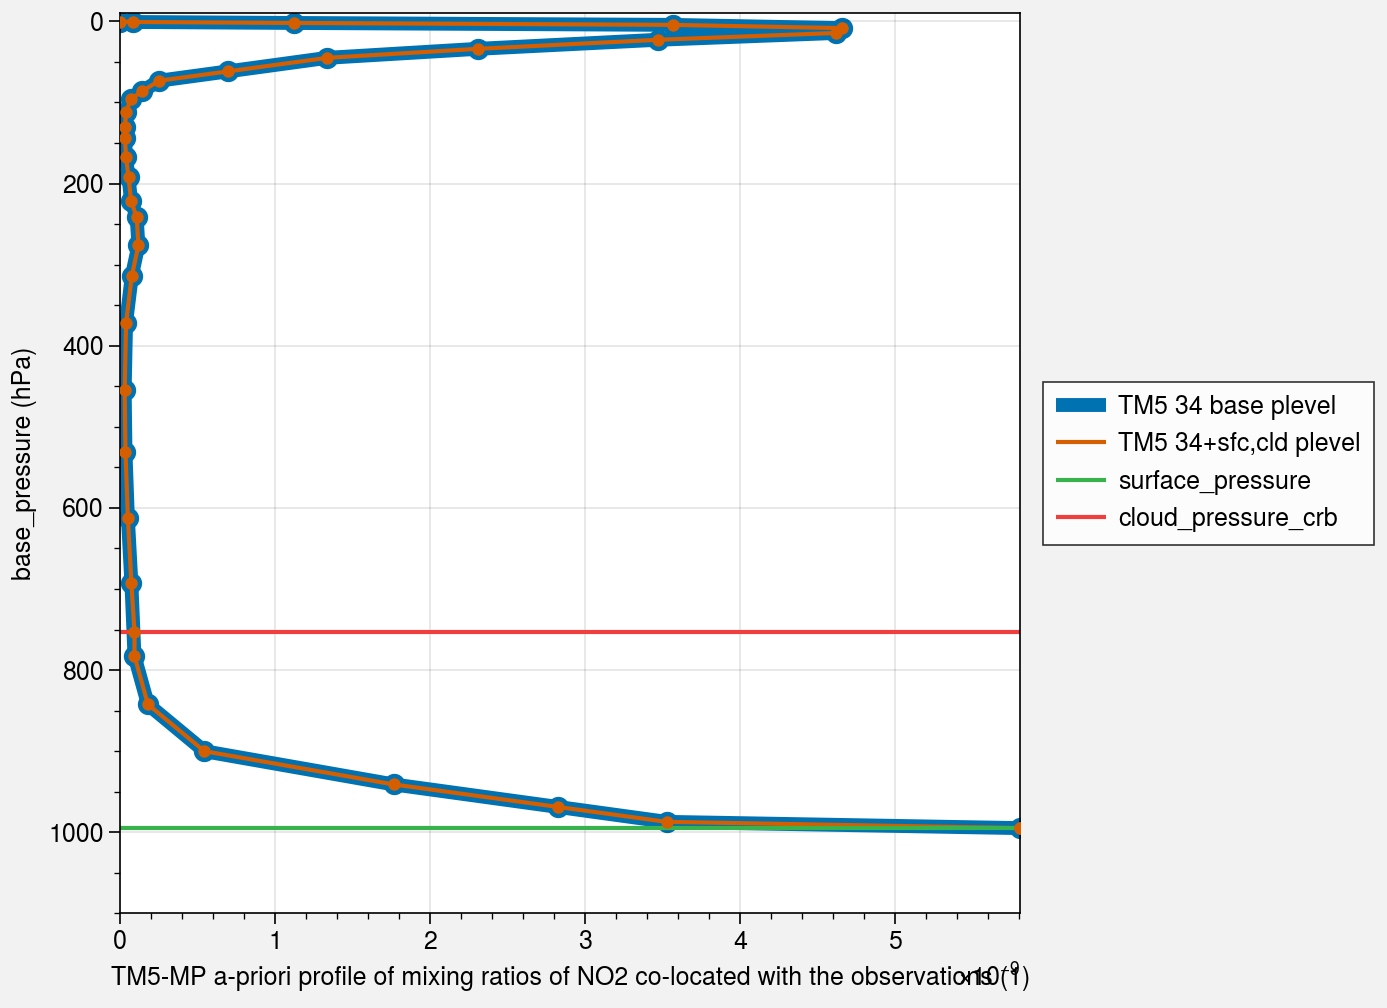

In [23]:
fig, axs = plot.subplots(axwidth=4.5)

# plot the TM5 no2 profile at default base pressures
l1 = axs.plot(ds['no2_vmr'], ds['base_pressure'], linewidth=5, label='TM5 34 base plevel')
axs.scatter(ds['no2_vmr'], ds['base_pressure'], s=50)

# plot the concatenated values
l2 = axs.plot(no2_profile, p_level, label='TM5 34+sfc,cld plevel')
axs.scatter(no2_profile, p_level, s=15, zorder=10)

l3 = axs.axhline(ds['surface_pressure'], color='green7', label='surface_pressure')
l4 = axs.axhline(ds['cloud_pressure_crb'], color='red7', label='cloud_pressure_crb')

axs.format(xlim=(0, ds['no2_vmr'].max()), ylim=(1100, -10))
axs.legend([l1, l2, l3, l4], loc='r', ncols=1)

Added two points are crossed by the green and orange lines.

## Comparing products

### 1. Ghost column

The easiest and apparent one is `nitrogendioxide_ghost_column`.

User Manual (Page 64):

> The ghost column is the NO$_2$ profile shape from TM5 integrated over the model layers from
the surface to the cloud pressure level. (The ghost column does not have a associated
precision estimate.)

We need to pick base_pressure below cloud pressure (`p_level > ds['cloud_pressure_crb']`),
then the topest top_pressure is the cloud pressure level.

In [24]:
ghost_layer = ((p_level > ds['cloud_pressure_crb'] ) & (p_level <= ds['surface_pressure']))
ghost_layer

<xarray.DataArray (layer: 36)>
array([ True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])
Coordinates:
    ground_pixel  float64 246.0
    scanline      float64 1.815e+03
    time          datetime64[ns] 2019-07-25
    latitude      float32 35.749756
    longitude     float32 116.56032
Dimensions without coordinates: layer

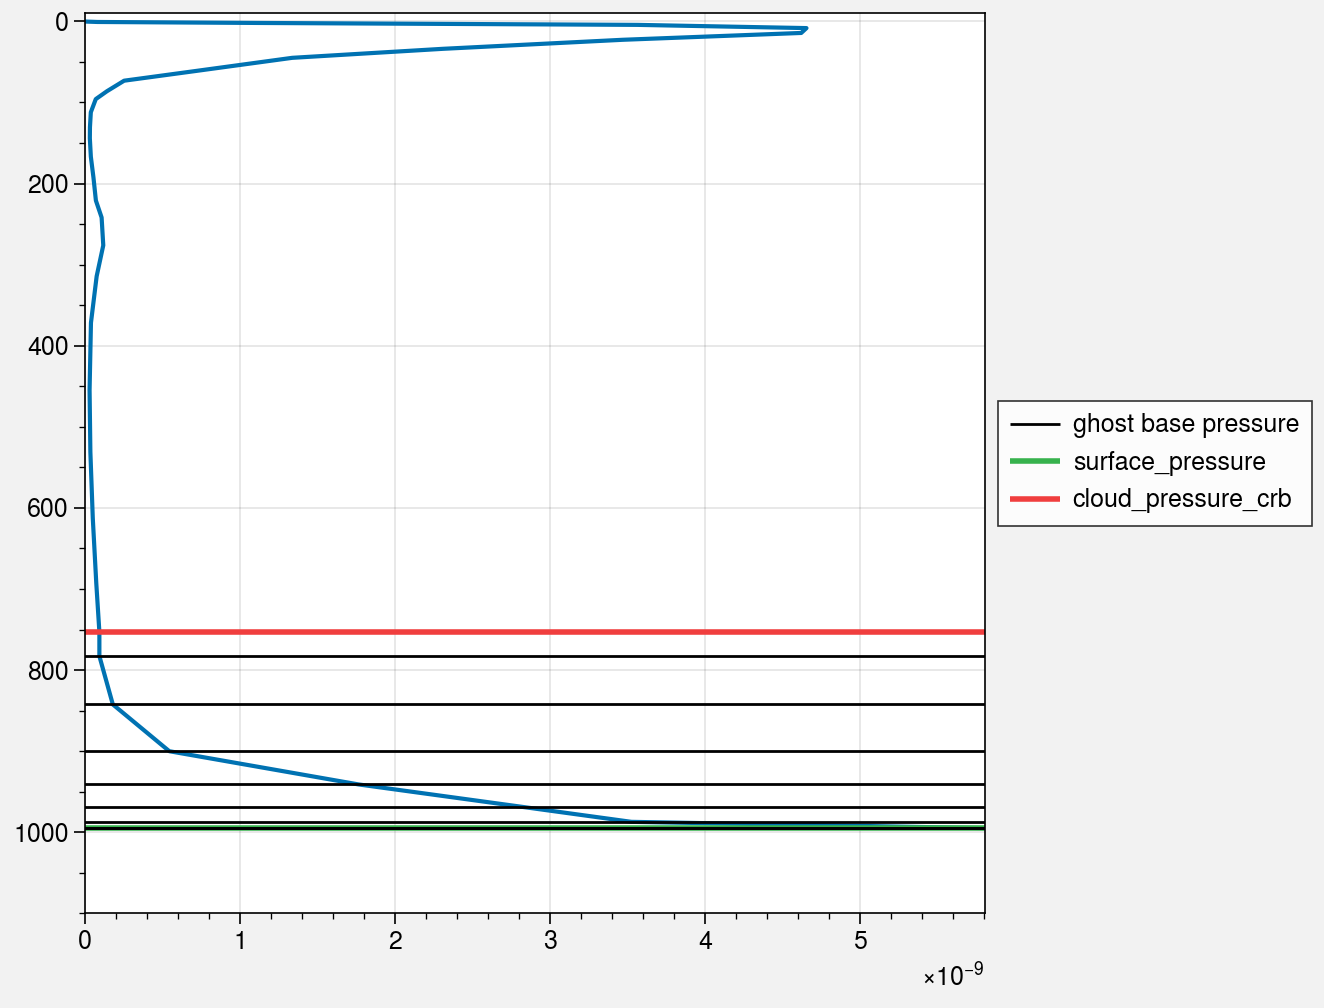

In [25]:
fig, axs = plot.subplots(axwidth=4.5)
axs.plot(no2_profile, p_level, label='TM5 34+sfc,cld plevel')

# plot ghost layers
for p in p_level[ghost_layer]:
    l1 = axs.axhline(p, color='k', label='ghost base pressure', linewidth=1, zorder=10)

l2 = axs.axhline(ds['surface_pressure'], color='green7', label='surface_pressure', linewidth=2)
l3 = axs.axhline(ds['cloud_pressure_crb'], color='red7', label='cloud_pressure_crb', linewidth=2)

axs.format(xlim=(0, ds['no2_vmr'].max()), ylim=(1100, -10))
axs.legend([l1, l2, l3], loc='r', ncols=1)

For integration, using `p_level` which is the base pressure levels is fine, as we only focus on the troposphere.

The trick is $p\_level_{base}[i+1] = p\_level_{top}[i]$

In [26]:
def integPr(no2_profile, p_level):
    '''Integrate the no2 profile

    Args:
        - no2_profile: no2 at full level
        - p_level: pressure at half level
    '''
    subcolumn = 10 * R *T0 /(g0*p0) \
              * no2_profile*1e6 \
              * abs(p_level.diff('layer')) * 2.6867e16 # DU to moleclues/cm2

    return subcolumn

In [27]:
subcolumn = integPr(no2_profile[:-1], p_level)
ghost_xin = subcolumn.where(ghost_layer[:-1]).sum('layer')
display(subcolumn.where(ghost_layer[:-1]))

<xarray.DataArray (layer: 35)>
array([0.0000000e+00, 9.5431113e+14, 1.3712496e+15, 1.6667437e+15,
       1.5324131e+15, 6.6457968e+14, 2.2571652e+14, 5.7988300e+13,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan], dtype=float32)
Coordinates:
    ground_pixel  float64 246.0
    scanline      float64 1.815e+03
    time          datetime64[ns] 2019-07-25
    latitude      float32 35.749756
    longitude     float32 116.56032
Dimensions without coordinates: layer

In [28]:
print(f"Official: {ds['nitrogendioxide_ghost_column'].values}, Xin: {ghost_xin.values}")

Official: 6456797745381376.0, Xin: 6473002120118272.0


<span style="color:red">**My `nitrogendioxide_ghost_column` is larger than the official one.
    Why ???**</span>

### 2. AMF

#### Calculate bAMF

This is the function of calculate bAMF.

<span style="color:red">**Because no$_2$ is at full levels,
    we need to assume the corresponding full pressure level is the mean of base_pressure and top_pressure.
    Is this correct?**</span>

In [29]:
def cal_bamf(lut, p_full_level, albedo, cld_albedo, p_sfc, p_cld, dphi, mu0, mu):
    '''Calculate the Box-AMFs at full levels based on the LUT file

    Args:
        - p_level: pressure at full level
        - albedo: Surface albedo
        - cld_albedo: Cloud albedo
        - p_sfc: Surface pressure
        - p_cld: Cloud pressure
        - dphi: Relative azimuth angle
        - mu: Cosine of viewing zenith angle
        - mu0: Cosine of solar zenith angle
        - amf: Box air mass factor
    '''

    da = lut['amf'].assign_coords(p=np.log(lut['amf'].p), p_surface=np.log(lut['amf'].p_surface))
    da = da.where(da>0, 0)

    bAmfClr_p = da.interp(albedo=albedo,
                                  p_surface=np.log(p_sfc),
                                  dphi=dphi,
                                  mu0=mu0,
                                  mu=mu,
                                  ).isel(pixel=0, layer=0)

    bAmfCld_p = da.interp(albedo=cld_albedo,
                                  p_surface=np.log(p_cld),
                                  dphi=dphi,
                                  mu0=mu0,
                                  mu=mu,
                                  ).isel(pixel=0, layer=0)

    # interpolate to TM5 full pressure levels
    
    bAmfClr = bAmfClr_p.interp(p=np.log(p_full_level.values))
    bAmfCld = bAmfCld_p.interp(p=np.log(p_full_level.values))

    return bAmfClr_p, bAmfCld_p, bAmfClr, bAmfCld

Notes of the function above:

- `da = da.where(da>0, 0)`: set negative bamf values in lut data to 0

In [30]:
p_full_level = p_level.rolling({'layer': 2}).mean()[1:, ...]

bAmfClr_p, bAmfCld_p, bAmfClr, bAmfCld = cal_bamf(lut, p_full_level,
                            ds['surface_albedo'].expand_dims('pixel'),
                            ds['cloud_albedo_crb'].expand_dims('pixel'),
                            p_sfc, p_cld,
                            ds['relative_azimuth_angle'].expand_dims('pixel'),
                            np.cos(np.deg2rad(ds['solar_zenith_angle'])).expand_dims('pixel'),
                            np.cos(np.deg2rad(ds['viewing_zenith_angle'])).expand_dims('pixel'),
                            )

#### bAMF overview

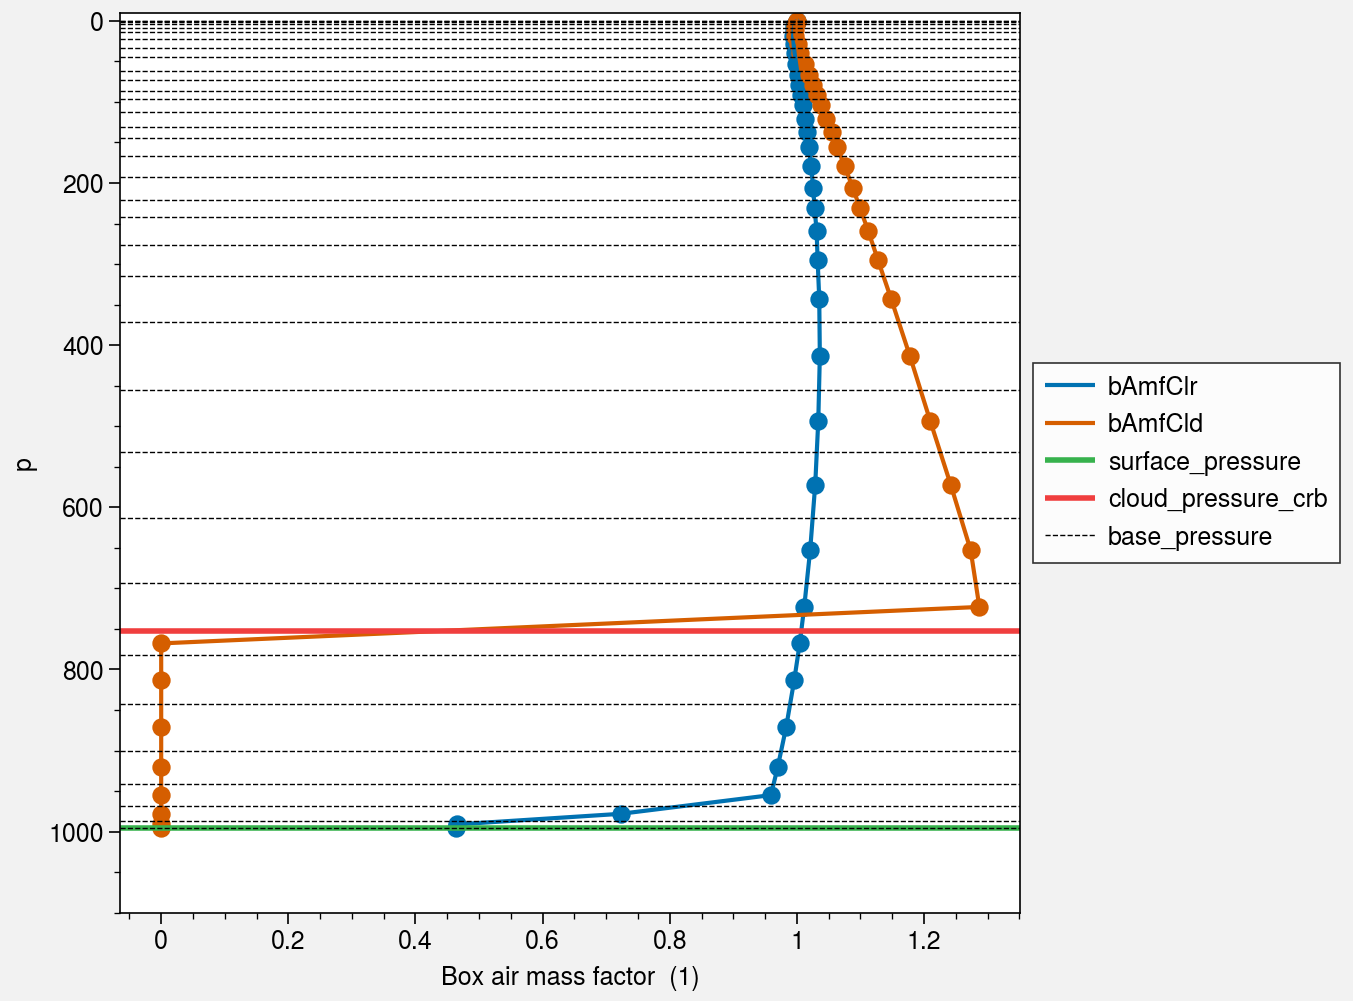

In [31]:
fig, axs = plot.subplots(axwidth=4.5)

l1 = axs.plot(bAmfClr, np.exp(bAmfClr.p), label='bAmfClr')
l2 = axs.plot(bAmfCld, np.exp(bAmfCld.p), label='bAmfCld')
l3 = axs.axhline(ds['surface_pressure'], color='green7',
                 label='surface_pressure', linewidth=2)
l4 = axs.axhline(ds['cloud_pressure_crb'], color='red7',
                 label='cloud_pressure_crb', linewidth=2)

for p in ds['base_pressure']:
    l5 = axs.axhline(p, color='k',
                     linestyle='--', linewidth=0.5,
                     label='base_pressure',
                     zorder=10)

axs.scatter(bAmfClr, np.exp(bAmfClr.p))
axs.scatter(bAmfCld, np.exp(bAmfCld.p))

axs.format(ylim=(1100, -10), grid=False)
axs.legend([l1, l2, l3, l4, l5], ncols=1, loc='r')

#### Add tk for temperature correction

Note that the `tk` at pressure full level should be interpolated too.

Let's compare the `tk` with and without interpolation:

In [32]:
# without interpolation
tk_sfc = ds['temperature'].sel(layer=id_sfc)
tk_cld = ds['temperature'].sel(layer=id_cld)
tk_nointerp = xr.concat([ds['temperature'], tk_sfc, tk_cld], dim='layer')
tk_nointerp = xr.DataArray(np.take_along_axis(tk_nointerp.values, sort_index, axis=0), dims=['layer'])

# with interpolation
tk = ds['temperature'].rename({'layer': 'p'})\
                      .assign_coords({'p': np.log((ds['base_pressure'] + ds['top_pressure'])/2).values})\
                      .interp(p=np.log(p_full_level.values), kwargs={"fill_value": 'extrapolate'})
display(tk_nointerp, tk)

<xarray.DataArray (layer: 36)>
array([305.0632 , 305.0632 , 303.8197 , 302.10782, 299.75592, 296.7925 ,
       292.90692, 287.26373, 287.26373, 281.0731 , 275.6525 , 270.21365,
       262.72113, 253.8881 , 246.67293, 239.97964, 233.88739, 227.92996,
       220.5284 , 213.4229 , 207.85062, 203.13438, 199.96703, 199.89056,
       202.00761, 205.3461 , 211.17163, 215.1766 , 218.83965, 224.92757,
       230.27176, 236.52907, 252.95595, 259.40762, 250.41304, 228.33493],
      dtype=float32)
Dimensions without coordinates: layer

<xarray.DataArray 'temperature' (p: 35)>
array([305.4293 , 305.0632 , 303.8197 , 302.10782, 299.75592, 296.7925 ,
       292.90692, 289.59857, 286.23218, 281.0731 , 275.6525 , 270.21365,
       262.72113, 253.8881 , 246.67293, 239.97964, 233.88739, 227.92996,
       220.5284 , 213.4229 , 207.85062, 203.13438, 199.96703, 199.89056,
       202.00761, 205.3461 , 211.17163, 215.1766 , 218.83965, 224.92757,
       230.27176, 236.52907, 252.95595, 259.40762, 250.41304],
      dtype=float32)
Coordinates:
    ground_pixel  float64 246.0
    scanline      float64 1.815e+03
    time          datetime64[ns] 2019-07-25
    latitude      float32 35.749756
    longitude     float32 116.56032
  * p             (p) float32 6.9026937 6.898793 ... 0.26566318 -0.8195099
Attributes:
    units:                K
    long_name:            TM5-MP temperature profile
    standard_name:        air_temperature
    coordinates:          /PRODUCT/longitude /PRODUCT/latitude
    ancillary_variables:  /PRODUCT/tm5_constant_a /PRODUCT/tm5_constant_b /PR...

#### Calculate AMFClr and AMFCld

In [33]:
# the temperature correction factor, see TROPOMI ATBD file
factor = 1 - 0.00316*(tk.rename({'p': 'layer'})-ts) + 3.39e-6*(tk.rename({'p': 'layer'})-ts)**2


# get the scattering weights
clearSW = no2_profile[:-1] * bAmfClr.values * factor
cloudySW = no2_profile[:-1] * bAmfCld.values * factor

# calculate the subcolumn
subcolumnClr = integPr(clearSW, p_level)
subcolumnCld = integPr(cloudySW, p_level)

# layer
ghost_layer = ((p_level > ds['cloud_pressure_crb'] ) & (p_level <= ds['surface_pressure']))
tropo_layer = ((p_level > ds['base_tropo']) & (p_level <= ds['surface_pressure']))[:-1]
cld_layer = ((p_level > ds['base_tropo']) & (p_level <= ds['cloud_pressure_crb']))[:-1]

# sum the subcolumn
scdClr = subcolumnClr.where(tropo_layer).sum('layer')
scdCld = subcolumnCld.where(cld_layer).sum('layer')

# vcd
vcdGnd = subcolumn.where(tropo_layer).sum('layer')

# calculate amf
amfClr = scdClr/vcdGnd
amfCld = scdCld/vcdGnd

In [34]:
print(f"Official amfClr: {ds['air_mass_factor_clear'].values}, Xin: {amfClr.values}")
print(f"Official amfCld: {ds['air_mass_factor_cloudy'].values}, Xin: {amfCld.values}")

Official amfClr: 0.8270235061645508, Xin: 0.6740226399522028
Official amfCld: 0.2376982867717743, Xin: 0.11156868488802561


<span style="color:red">**Both `amfClr` and `amfCld` are smaller than the official values, expecially `amfCld` ...**</span>

### Bak scripts

When the DataArray is multidimension, we need the `xr.apply_ufunc` function.

Since this one pixel doesn't need it, I keep the function at the end for later usage.

In [35]:
# def interp1d_sp(data, x, xi):
#     '''Linear interpolate function'''
#     f = scipy.interpolate.interp1d(x, data, fill_value='extrapolate')

#     return f(xi)


# def xr_interp(input_array,
#               input_p, input_p_dimname,
#               interp_p, interp_p_dimname):
#     '''Interpolate 3D array by another 3D array

#     Args:
#         input_array:
#                 the original array
#                 - dims: input_p_dimname, y, x
#         input_p:
#                 pressure of the original array
#                 - dims: input_p_dimname, y, x
#         interp_p:
#                 the pressure levels which input_array is interpolated to
#                 - dims: interp_p_dimname, y, x
#         input_p_dimname:
#                 the name of the vertical dim for input_p
#         interp_p_dimname:
#                 the name of the vertical dim for interp_p

#     '''

#     return xr.apply_ufunc(
#         interp1d_sp,
#         input_array,
#         input_p,
#         interp_p,
#         input_core_dims=[[input_p_dimname], [input_p_dimname], [interp_p_dimname]],
#         output_core_dims=[[interp_p_dimname]],
#         exclude_dims=set((input_p_dimname,)),
#         vectorize=True,
#         output_dtypes=[input_array.dtype],
#     )

In [36]:
# # interpolate to TM5 pressure levels
# # bAmfClr = xr_interp(bAmfClr_p,
# #                     bAmfClr_p.coords['p'],
# #                     'p',
# #                     np.log(p_level.rolling({'layer': 2}).mean()[1:, ...]),
# #                     'layer')

# bAmfClr = xr_interp(bAmfClr_p,
#                     bAmfClr_p.coords['p'],
#                     'p',
#                     np.log(p_level.rolling({'layer': 2}).mean()[1:, ...]),
#                     'layer')

# bAmfClr